# [EADS 2024-2025] Projet Maths-Info : Travelling Salesman Problem
Dans le cadre de l'UE Projet Maths-Info en L3 Informatique : Mathématiques-Informatique à l'AMU

## Contributeurs
* Alexandre ROMANO
* Victoria BOUCHET
* Vahé TILDIAN

Le <strong>Problème du Voyageur de Commerce</strong>, abrégé en TSP, est un problème d'optimisation combinatoire assez emblematique dans le monde de l'informatique théorique.

Il consiste à déterminer un chemin de longueur minimale passant exactement une fois par ville et revenant au point de départ, dans un réseau de $n$ villes. 

Cette approche est $NP$-difficile, ce qui signifie qu'ajourd'hui, aucune approche exixtante permet d'obtenir la solution optimal à ce problème. 
Ce qui le rend emblématique est sa difficulté de résolution amlgré un énoncé très simple.

$\fbox{Le Projet}$

Notre projet consiste à explorer plusieurs <strong>heuristiques</strong> <i>(ce sont des méthodes permettant d'obtenir une solution faisable, une résolution mais pas forcément optimale)</i> et de les étudier afin d'évaluer leurs résultats, en fonction de leur qualité et de leur temps d'exécution.

Nous avions le choix d'implémenter au minimum 2 des heuristiques proposé dans ce projet, nous avons finalement étudié 4 heuristiques : 

<u>Nearest Neighbor</u>, heuristique gloutonne qui nous servira pour d'autres méthode de solution initiale
<u>Cheapest Insertion</u>, qui apporte une approche plus détaillée que Nearest Neighbor mais reste une heuristique gloutonne
<u>Two-Opt</u>, heuristique de recherche locale se basant sur des 2-permutations
<u>Simulated Annealing</u>, apportant une part d'aléatoire pour améliorer Two-Opt

## Conception d’un germinateur de villes : code d'une fonction générant n villes et d'une matrice de distances.

### Génération d'un ensemble de villes et la distance entre elles ##
Peut être généré en produisant une matrice tel que pour la i-ème ville et j-ième ville on ait 

$[len(i,i) = 0, len(i,j), len(i,j+1) ... ]$

et

$[len(j,i), len(j,j) = 0, len(j+1,j+1) ... ]$ $.$

In [1]:
import numpy as np
import random

In [2]:
class City:
    
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.id = id

    def distance_to(self, other: 'City'):
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)   # Distance euclidienne entre deux villes en fonction des coordonnées

Nous faisons le choix de créer une classe pour pouvoir itérer sur des objets de type City (ville) et pouvoir produire une matrice des distances entre chaque ville 

In [3]:
def distance_matrix(matrix_size):
    cities = [City(random.uniform(0, 100), random.uniform(0, 100), i) for i in range(matrix_size)] # Liste contenant n villes (selon matrix_size) avec des coordonnées aléatoires
    distance_matrix = np.zeros((len(cities), len(cities)))                                         # La matrice est remplie de 0 pour l'initialiser

    for i, city1 in enumerate(cities):
        for j, city2 in enumerate(cities):
            distance_matrix[i][j] = city1.distance_to(city2)                                       # Calcul des distances entre chaque ville

    # Retour des coordonnées des villes pour la visualisation
    coords = [(v.x, v.y) for v in cities]
    
    return distance_matrix, coords

## Implémentation des heuristiques : Nearest Neighbor, Nearest Insertion, 2-opt, Simulated Annealing.

### Nearest Neighbor ###


$\fbox{Nearest Neighbor}$

Une première approche permettant de résoudre le TSP est l'heuristique du plus proche voisin (__Nearest Neighbor__) consiste à rejoindre le noeud voisin a la plus courte distance de celui en cours. Cette approche est simple à comprendre et implementer, mais produit souvent le chemin le plus long comme nous le verrons plus tard.

In [4]:
def nearest_neighbor(distance_matrix):
    """
    MÉTHODE DU VOISIN LE PLUS PROCHE : 
    Approche heuristique simple pour résoudre le TSP.
    Consiste tout simplement à chercher la ville la plus proche de la ville d'origine et ainsi de suite.
    
    Très rapide (mais pas du tout optimal) et permet d'offrir une base sur laquelle on peut apporter des améliorations (2-opt, simulated annealing)
    """
    n = len(distance_matrix)
    unvisited = set(range(n))   # Liste des villes non visitées
    current = 0
    path = [current]
    unvisited.remove(current)

    while unvisited:
        nearest = min(unvisited, key=lambda city: distance_matrix[current][city])   # On cherche la ville la plus proche
        path.append(nearest)                                                        # On l'ajoute au chemin final
        current = nearest
        unvisited.remove(nearest)                                                   # On enlève la ville la plus proche de unvisited

    path.append(path[0])                                                            # On ajoute la ville 0 pour compléter la boucle
    return path

### Code de l'heuristique d'insertion minimale ##

$\fbox{Insertion Minimale}$

L'insertion minimale est une <strong>heuristique gloutonne</strong> qui aide à construire une solution initiale, souvent plus optimale que celle du Nearest Neighbor, au TSP. L'idée est de construire progressivement un chemin, en insérant à chaque tour la ville non encore visitée, en s'assurant que cet ajout augmente le moins possible le coût total du chemin.


In [5]:
def cheapest_insertion(distance_matrix):
    """
    METHODE D'INSERTION : 
    Construit une solution approchée du TSP par heuristique d'insertion

    La fonction prend en entrée une matrice carrée des distances entre les villes et
    renvoie un ordre de visite minimisant approximativment la distance totale du chemin

    """
    n = len(distance_matrix)                             #Nombre total des villes
    unvisited = list(range(n))                           #Liste des idices des villes non inserees dans le circuit
    path = [unvisited.pop(0), unvisited.pop(0)]          #Initialisation du chemin avec les deux premières villes


    while unvisited:
        #Recherhce la meilleure ville à inserer et de sa position optimale

        best_cost = float('inf')                            #Init avec la valeur infini pour technique borne inférieur
        best_place = None
        to_insert = None                                    #Ville à insérer lorsque celle-ci augmente le moins le coût total du chemin

        for v in unvisited:                                 #Insertion de chaque ville restantes une à une
            for i in range(len(path)):
                test_path = path[:i+1] + [v] + path[i+1:]   #Création d'un nouveau chemin hypothétique ave la ville v
                new_cost = total_path_distance(test_path, distance_matrix)

                #Si l'insertion donne un meilleur cout alors on la garde en mémoire comme meilleure option
                if new_cost < best_cost:
                    best_cost = new_cost    
                    best_place = i+1
                    to_insert = v

        #Insertion de la meilleure ville à la meilleure position
        path.insert(best_place, to_insert)
        unvisited.remove(to_insert)

    path.append(path[0])
    return path

Cet algorithme prend en entrée :

- $dist\_matrix$ qui représente une matrice carrée $D$ des distance, comme celle évoque pour $2-opt$. 

En sortie, nous obtiendrons un circuit complet <strong>fermé</strong> (avec une liste d'indices de villes) qui commence et termine à la même ville de départ.

Tout d'abord on initialise $path$ avec les deux premières villes (0 et 1) et la liste $unvisited$ qui contient les villes restantes. 

Ensuite tant qu'il reste des villes qui n'ont pas été visitées pour chaque ville $v$ :

- On va tester toutes les positions d'insertion possibles dans le chemin actuel
- On calcule le coût total du chemin avec $path\_length\_matrix$ lorsqueb $v$ est supposément inséré à cette position.
- On garde l'insertion qui produit le coût total
Enfin on va insérer la meilleur ville trouvée à la meilleure position

L'algorithme s'arrête lorsque toutes les villes sont dans le chemin.

### Implementation de la méthode 2-opt ###


$\fbox{2-OPT}$

Le 2-OPT est une méthode simple pour améliorer un trajet. Elle consiste à échanger deux segments d’un trajet si cela permet de raccourcir le chemin total. On répète jusqu’à ce qu’aucun échange ne donne de meilleur résultat.

In [6]:
#Code permettant de résoudre le TSP avec la méthode 2-opt
#Se basant sur des 2-permutations

def two_opt(path, distance_matrix):
    """
    METHODE 2-OPT : Amélioration d'un chemin du TSP
    Prend en entrée un chemin (une liste d'indices) et une matrice de distance
    Renvoie un chemin amélioré à l'aide de 2-permutations (inversion d'arête)
    """
    n = len(path)
    improve = True              #Initialisation du booléen d'amélioration à Vrai

    max_iterations = 1000       #Maximum d'itération avant arrêt de l'algorithme
    iteration = 0               #Comptage d'itération

    while improve and iteration < max_iterations:         #Evite que le calcul ne boucle trop longtemps lorsque la solution initiale n'est pas du tout optimale
        improve = False
        iteration += 1
    
        for i in range(n-1):
                for j in range(i+2, n if i>0 else n-1):   #Empêche les inversions invalides
                    a, b = path[i], path[i+1]             # a --> b
                    c, d = path[j], path[(j+1)%n]         # c --> d
                    
                    #Calcul du gain de distance
                    delta = -distance_matrix[a][b] -distance_matrix[c][d] + distance_matrix[a][c] + distance_matrix[b][d]

                    if delta < 0 :                       #Si delta est négatif, il y a un gain donc on procède à l'échange des arêtes
                        path[i+1:j+1] = reversed(path[i+1:j+1])
                        improve = True

        if iteration >= max_iterations :                 #Condition permettant d'éviter de rallonger le calcul lorsque la solution initale n'est pas du tout optimale 
             print(f"Avertissement : Arret apres {iteration} iterations, limite maximum\n")
    return path


Cette fonction prend en entrées: $path$ une liste représentant un ordre de visite des villes (par leurs indices) et $distance\_matrix$ une matrice contenant les distances entre chaque paire de villes.

Le code parcourt toutes les paires d’arêtes non adjacentes du chemin. Pour chaque paire $(a-b)$ et $(c-d)$, il calcule le gain de distance ($delta$) si on échange ces arêtes (c’est-à-dire qu’on remplace les segments $a-b$ et $c-d$ par $a-c$ et $b-d$).
Si cet échange réduit la distance totale ($delta$ < 0), il inverse la sous-séquence concernée pour effectuer l’échange.

Boucle principale :
La recherche continue tant qu’au moins un échange améliore la solution ($improve = True$).
Un nombre maximum d’itérations ($max_iterations$) est fixé pour éviter de boucler indéfiniment si jamais l’amélioration stagne.

Retour :
Une fois qu’aucun échange ne permet d’amélioration, ou que la limite d’itérations est atteinte, le chemin optimisé est retourné.

### Implementation de la méthode Annealing


$\fbox{Annealing}$

L’algorithme Simulated Annealing est une heuristique inspirée du processus de refroidissement des métaux. Pour le TSP, il explore différentes solutions en acceptant parfois des détériorations temporaires, afin d’éviter de rester bloqué dans un minimum local. Progressivement, la probabilité d’accepter ces mauvaises solutions diminue, permettant de converger vers un bon chemin.


In [7]:
import math
import random

def simulated_annealing(distance_matrix, path, lower_bound, initial_temperature, final_temperature, cooling_rate):
    """
    MÉTHODE DU RECUIT SIMULÉ :
    Technique inspirée de la métallurgie acceptant temporairement des solutions moins bonnes pour éviter les minimas locaux.
    Implique l'aléatoire et une diminution de la température au fil des itérations puis se base sur le 2-opt pour la permutation des arêtes.
    """
    n = len(path)
    best_length = lower_bound
    best_path = path
    T = initial_temperature
    iteration = 0
    while T > final_temperature:
        i = random.randint(0, n-1)              # La première ville est choisie au hasard
        j = (i + random.randint(2, n-2)) % n    # La deuxième ville est également choisie au hasard et forcément différente de la première
        if j < i:
            i, j = j, i                         # j est toujours après i dans l'ordre du chemin
            
        delta = distance_matrix[path[i]][path[j]] + distance_matrix[path[i+1]][path[(j+1) % n]]\
                - distance_matrix[path[i]][path[i + 1]] - distance_matrix[path[j]][path[(j + 1) % n]] # Calcule la variation de la longueur totale du chemin s'il y a une inversion
                
        if delta < 0 or math.exp(-delta / T) > random.random():             # Si delta négatif, amélioration donc on accepte, sinon on accepte en fonction de delta et de la température
            lower_bound = lower_bound + delta
            for k in range((j - i) // 2):
                path[k + i + 1], path[j - k] = path[j - k], path[k + i + 1] # Inversion d'arête venant du 2-opt

        # Vérifie s'il y a une amélioration de la solution
        if best_length > lower_bound:
            best_length = lower_bound
            best_path = path
        iteration += 1
        if iteration % (n * n) == 0:
            T *= cooling_rate # Réduction de la température
            
    return best_path, best_length

La matrice des distances entre les villes est donne dans $distance\_matrix$.

La solution initiale est donne dans $path$. 

La solution initiale est donne dans $lower\_bound$.

Les paramètres de température sont donnees dans $initial\_temperature, final\_temperature$.

Le facteur de refroidissement est donne dans $cooling\_rate$.

À chaque itération, on sélectionne aléatoirement deux positions $i$ et $j$ dans le chemin.

On calcule le gain ou la perte ($delta$) qu’on obtiendrait en inversant le segment entre ces deux positions (inspiration du 2-OPT).

Si l’échange améliore la solution ($delta$ < 0), on l’accepte.
Sinon, on peut quand même l’accepter avec une probabilité qui dépend de $delta$ et de la température actuelle T ( via la formule $exp(-delta/T)$ ).

La température diminue progressivement (refroidissement) selon le $cooling\_rate$. Plus la température est basse, moins des détériorations sont acceptées

On garde en mémoire la meilleure solution rencontrée au cours des itérations.

En sorties nous avons donc: $best\_path$, le meilleur chemin trouvé, $best\_length$ : la longueur du meilleur chemin trouvé.



## Visualisation des résultats : graphiquement et statistiquement ##

### 1. Fonction affichant graphiquement les chemins

In [8]:
import matplotlib.pyplot as plt

def plot_path(coord, paths, names):
    """
    Visualisation des chemins obtenus avec :
        coord = Liste des coordonnées
        path = Ordre des villes visitées 
        name = nom de la technique utilisée
    
    """
    fig, axis = plt.subplots(1, len(paths), figsize=(5 * len(paths), 6))
    
    if len(paths) == 1: #Si un seul chemin: objet unique
        axis = [axis]

    for ax, path, name in zip(axis, paths, names):
        path_coords = [coord[i] for i in path] + [coord[path[0]]]
        
        # Séparation des coordonnées x et y pour créer deux listes avec chacune d'entre elles
        x_path, y_path = zip(*path_coords)
        
        # --- VISUALISATION DU CHEMIN OBTENU ---
        ax.plot(x_path, y_path, 'ro-', label ='Chemin TSP', markersize=5) #r --> rouge ; o --> marqueur cercle ; "-" --> relié par des lignes 
        
        # --- AFFICHAGE DES NUMEROS DE VILLES --
        # Parcours des coordonnées (x,y) originales pour associer à chaque numéros des villes 'i' avec un décalage pour la lisibilité
        for i, (x,y) in enumerate(coord):
            #Affiche le numéro de la ville 'i' (on décale un peu pour la lisibilité)
            ax.text(x,y + 1.5, str(i), color='blue', fontsize=12, ha='center') # ha=center --> Aligner horizontalement les numéros de villes aux cercles

        # Mise en évidence du point de départ
        start_city_coords = coord[path[0]]
        ax.plot(start_city_coords[0], start_city_coords[1], 'go', markersize=10, label="Ville de départ") #g --> vert ; o --> marqueur cercle


        # --- MISE EN FORME DU GRAPHIQUE ---
        ax.set_title(f"Méthode {name}")
        ax.set_xlabel("Coordonnée x")       #Axe des x
        ax.set_ylabel("Coordonnée y")       #Axe des y
        ax.legend()
        ax.grid(True)                       #Grille pour permettre une meilleure visualisation des chemins
        ax.axis('equal')                    #Evite les distorsions des axes x et y 
    
    plt.tight_layout()
    plt.show()                              #Affichage de la fenêtre

Cette fonction prend en entrée : 

- $coord$ représentant les coordonnées $(x,y)$ de chaque ville $v$
- $paths$ est une liste de chemins dont chaque chemin est une liste d'indice représentant l'ordre des villes visitées selon chaque algorithme
- $names$ représente la liste des noms des méthodes utilisées pour génrer les chemins de $paths$ (donc Nearest Neighbor, 2-opt, Simulated Annealing et Cheapest Insertion)

Pour chaque chemin, cette fonction trace les circuits TSP avec des lignes rouge reliant chaque ville, ensuite affiche les indices des villes en bleu et chacun d'entre elle sont représenté par un point bleu. La ville de départ est marquée en vert.

Plusieurs techniques sont utilisées pour optimiser l'algorithme et le rendu final :
- Nous égalisons les axes pour éviter certains distorsions de distances
- Les titres, legendes et axes propres sont ajoutés à chaque sous graphes
- Si nous avons qu'un chemin, nous traitons le cas seulement à travers la ligne

$if$ $len(paths == 1 : axis = [axis])$

- Nous décompressons les coordonnées à l'aide de 

$zip(*path\_coords)$

Ainsi pour chaque chemin fourni nous : 

- Créeons une sous-figure distinctes, pour afficher le chemin associé à telle méthode
- Traçons le chemin, en reliant les villes dans l'ordre donné par $path$
- Affichons les numéros de villes pour chaque point
- Mettons en évidence la ville de départ
- Enfin nous ajoutons les éléments viuels des graphiques comme les titres, légendes, axes etc...

### 2. Fonction calculant la distance total parcourue

Cette fonction calcule la distance totale d’un chemin pour le problème du voyageur de commerce (TSP).

In [9]:
def total_path_distance(path, distance_matrix):
    path_length = 0
    for i in range(len(path) - 1):         # On cumule les distances entre les villes i et i + 1                    
        path_length += distance_matrix[path[i]][path[i + 1]]
    path_length += distance_matrix[path[-1]][path[0]]
    return path_length

La liste représentant l’ordre des villes visitées est donnée dans $path$.
Une matrice donnant les distances entre toutes les paires de villes est donnée $distance\_matrix$.

La fonction additionne les distances entre chaque ville consécutive du chemin, puis ajoute la distance entre la dernière ville et la première pour fermer le cycle (retour au point de départ).

Ainsi, la fonction retourne la longueur totale du trajet parcouru.

## Fonctions permettant d'evaluer la qualite de l'algorithme ###

### Fonction qui testera la qualité et les performances d'un algorithme TSP ###


In [10]:
import time

def gap(total_path_distance, lower_bound):
    return f"{(total_path_distance - lower_bound) / lower_bound * 100} %"   # Calcule l'écart relatif entre la distance trouvée et la borne inférieure en pourcentage

def evaluate_quality(name, algo, distance_matrix, lower_bound):
    start_time = time.process_time()    # Début du chronomètre
    
    path = total_path_distance(algo, distance_matrix)
    print(f'Route la plus courte pour l\'algorithme " {name} " : \n{algo}')
    print("Longueur totale du chemin trouvé : {:.3f}".format(path))
    print(f"Qualité de la solution par rapport à la borne inférieure (Nearest Neighbor) : {gap(path, lower_bound)} de distance")
    
    end_time = time.process_time()      # Fin du chronomètre
    print(f"Temps de calcul : {end_time} s\n")

La fonction gap nous donne l'écart entre l'algorithme actuellement testé et la solution initiale.

Via un chronomètre, la fonction evaluate_quality determine combien de temps prend l'algorithme pour terminer.
Le nom de l'algorithme testé est donné dans $name$. L'algorithme en tant que tel est donné dans $algo$.
La matrice des distances est donnée dans $distance\_matrix$. La borne inférieure, utile à la comparaison, est donnée dans $lower\_bound$.


## Evaluation de la qualite des algorithmes

Dans le code ci-dessous, nous comparons les différents algorithmes implementés. Nous décidons de les confronter en générant 50 villes.
Tout d'abord, nous exécutons le code de l'heuristique __Nearest Neighbor__ (du Plus Proche Voisin). Le résultat obtenu servira de base de comparaison, grace à la variable $lower\_bound$ (borne inférieure, car nous verrons que __Nearest Neighbor__ donne systématiquement la distance la plus longue) qui restera fixé jusqu'à la fin de notre évaluation.

Le chemin de __Nearest Neighbor__ est copié et réutilisé par les algorithmes __2-Opt__ et __Simulated Annealing__ qui chercheront à l'améliorer.


In [11]:

distance_matrix, coords = distance_matrix(50)

print("Matrice des distances entre les villes: \n")
print(distance_matrix)
print("\n")
print("Note : si le pourcentage est négatif il y a amélioration, si le pourcentage est positif alors il y a dégradation par rapport à Nearest Neighbor.")

algo1 = nearest_neighbor(distance_matrix)
lower_bound = total_path_distance(algo1, distance_matrix) # Référence pour les autres algorithmes
evaluate_quality("Nearest Neighbor", algo1, distance_matrix, lower_bound)

#Copie du chemin obtenu avec Nearest Neighbor, pour TwoOpt et Simulated Annealing
path = algo1.copy()

algo2 = cheapest_insertion(distance_matrix)
evaluate_quality("Cheapest Insertion", algo2, distance_matrix, lower_bound)

# Choix du chemin de Nearest Neighbor pour le calcul des deux prochaines heuristiques
algo3 = two_opt(path, distance_matrix)
evaluate_quality("2-Opt", algo3, distance_matrix, lower_bound)

# Paramètres de Simulated Annealing
initial_temperature = 5000
cooling_rate = 0.995
path = algo1.copy()
path.pop() # On enlève le dernier 0 de Nearest Neighbor pour éviter les doublons

algo4_path, algo4_length = simulated_annealing(distance_matrix, path, lower_bound, initial_temperature, 0.001, cooling_rate)
evaluate_quality("Simulated Annealing", algo4_path, distance_matrix, lower_bound)



Matrice des distances entre les villes: 

[[ 0.         23.31881535  8.27469165 ... 19.94250017 38.22269353
  46.23319786]
 [23.31881535  0.         19.06221778 ...  7.25795867 33.2765373
  67.05362678]
 [ 8.27469165 19.06221778  0.         ... 18.36017399 30.10580893
  48.01634762]
 ...
 [19.94250017  7.25795867 18.36017399 ...  0.         38.90156874
  65.66411996]
 [38.22269353 33.2765373  30.10580893 ... 38.90156874  0.
  58.71382608]
 [46.23319786 67.05362678 48.01634762 ... 65.66411996 58.71382608
   0.        ]]


Note : si le pourcentage est négatif il y a amélioration, si le pourcentage est positif alors il y a dégradation par rapport à Nearest Neighbor.
Route la plus courte pour l'algorithme " Nearest Neighbor " : 
[0, 27, 14, 42, 31, 11, 25, 23, 29, 4, 35, 19, 13, 17, 40, 21, 3, 34, 49, 36, 2, 20, 12, 47, 10, 1, 43, 38, 24, 32, 15, 8, 9, 37, 48, 44, 6, 30, 16, 5, 33, 7, 18, 22, 45, 41, 39, 28, 26, 46, 0]
Longueur totale du chemin trouvé : 664.284
Qualité de la solution par r

### Affichage des chemins

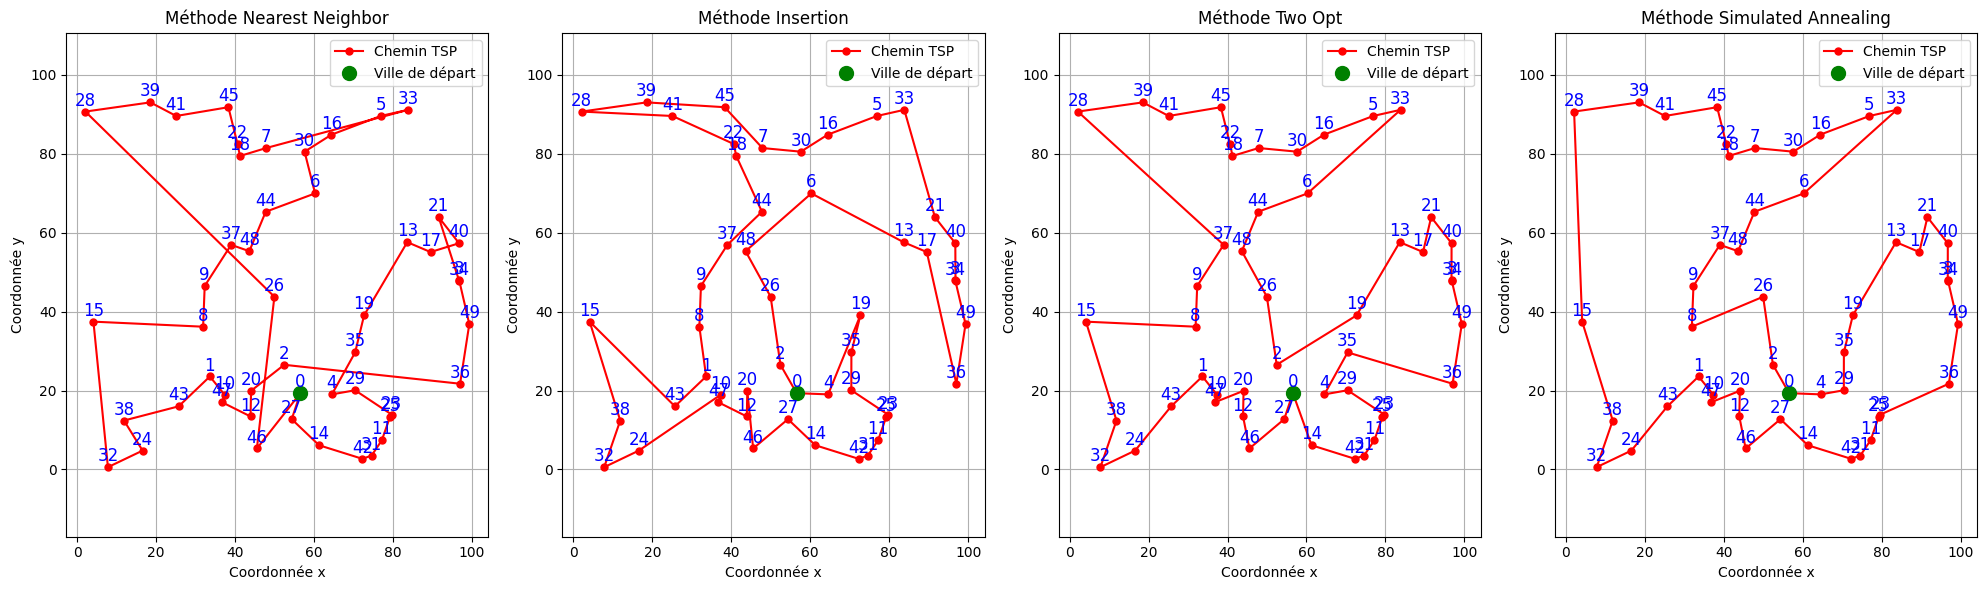

In [12]:
# Affichage sur la même figure des visualisations des 3 heuristiques
plot_path(coords, [algo1, algo2, algo3, algo4_path], ["Nearest Neighbor", "Insertion", "Two Opt", "Simulated Annealing"])